# Project 3: Image recognizion. (Melanoma)
### Group 7: Emma, Laurits, Malthe, Mads og Jonas


## Loading the Libraries

In [46]:
!apt update
!apt install ffmpeg libsm6 libxext6 -y

!pip install opencv-python
!pip install --upgrade pip

# needed to import cv2 and check photos for bluriness DONT DELETE

Hit:1 http://deb.debian.org/debian buster InRelease
Hit:2 http://deb.debian.org/debian buster-updates InRelease
Hit:3 http://security.debian.org/debian-security buster/updates InRelease



All packages are up to date.



ffmpeg is already the newest version (7:4.1.6-1~deb10u1).
libsm6 is already the newest version (2:1.2.3-1).
libxext6 is already the newest version (2:1.3.3-1+b2).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.


In [47]:
import numpy as np
import matplotlib.pyplot as plt
import os 
import fyp2021p3_group00_functions as util
import pandas as pd
from skimage import morphology
from skimage import filters
from skimage.morphology import opening
import cv2
from sklearn.model_selection import train_test_split
from skimage.exposure import is_low_contrast
from scipy.ndimage import rotate

## Functions

In [48]:
def check_quality(image_id_jpg, minimum_resolution):
    
    """ A Function that returns the number of pixels in an image that can
    be used to check whether the image is low or high quality"""

    im = plt.imread(PICTURES[image_id_jpg])
    resolution = im.shape
    num_of_pixels = resolution[0]*resolution[1]
    return num_of_pixels

In [49]:
def low_quality_pictures(resulotion, dictionary_):
    not_fine = 0
    fine = 0
    popped_image = []

    for i in dictionary_:   
        x = check_quality(str(i), High_Definition)
        if x >= High_Definition:
            fine += 1
        else: 
            not_fine += 1
            popped_image.append(i)

    # then we pop the images from the dictionary PICTURES that are low quality 
    for i in popped_image:
        dictionary_.pop(i)

    print('Fine: {0}, Not fine: {1}'.format(fine, not_fine))
    print('Image popped from the dict: {0}'.format(popped_image))

In [50]:
def bluriness(dictionary_):
    
    """This function takes a dictionary and checks whether the images
    in the dictionary are blurry or sharp and then removes the blurry images
    from the dictionary."""

    blurry_images = []
    not_blurry = 0
    blurry = 0
    for key, value in dictionary_.items():   
        x = cv2.imread(str(value))
        v = cv2.Laplacian(x, cv2.CV_64F).var()
        if v > 10:
            not_blurry += 1
        else: 
            blurry += 1
            blurry_images.append(key)

# now we delete the images from the dictionary that are blurry
    for i in blurry_images:
        dictionary_.pop(i)

    print('Not Blurry: {0}'.format(not_blurry))
    print('Blurry: {0}'.format(blurry))
    print("Blurry Images: {0}".format(blurry_images))

In [58]:
def contrast(dictionary_):

    """ The function takes a dictionary of images with the path as a value 
	to input and checks the contrast of the image"""

    high = 0
    low = 0
    low_ = []
    for key, value in dictionary_.items():
        x = cv2.imread(str(value))
        y = is_low_contrast(x)
        if y == True:
            low += 1
            low_.append(key)
        else:
            high += 1
            
    #Removes the low contrast from the PICTURES
    for i in low_:
        dictionary_.pop(i)

    print('Number of Images with High Contrast: {0}'.format(high))
    print('Number of Images with Low Contrast: {0}'.format(low))
    print("Images with Low Contrast: {0}".format(low_))

## Loading the data

In [60]:
# First we make the path to the data
PATH = {}
PATH["data"] ="../data"

#print(PATH)
#Then we load the path for all the diffirent as keys to their names.
PICTURES = {}
for path, subdirs, files in os.walk(PATH["data"]):
    for picture in files:
        # Making sure that we exclude the .csv from the dictionary, to only include images (ie. png and jpg files)
        if not str(picture).count(".csv", (len(picture) - 4),len(picture)):
            PICTURES[picture] = os.path.normpath(os.path.join(path, picture))

# Remove a last file from the PICTURES dictonary
PICTURES.pop(".DS_Store")

images = pd.read_csv("../data/example_ground_truth.csv")
images['id'] = images['image_id']
image_way = pd.DataFrame.from_dict(PICTURES, orient='index')
image_way['id'] = image_way.index
for number, name in enumerate(iterable = image_way['id']):
    image_way['id'][number] = name[0:12]
image_merge = images.merge(image_way, left_on ='image_id' , right_on = 'id', how = 'outer')
image_merge['healthy'] = 1-image_merge['melanoma']-image_merge['seborrheic_keratosis']
image_merge = image_merge.rename(columns ={0: 'path'})
image_merge['mask'] = image_merge['path'].str.contains('png')
image_merge['raw'] = image_merge['path'].str.contains('jpg')
# Reworking images to contain name and helath of all the images to use later.
images = images.dropna(axis=0)
images = images[images['seborrheic_keratosis']!= 1]


# Task 0: Explore the Data

Go through the data (csv file, images, segmentations) that you have available
to understand what’s available to you, and write a brief description. Decide if
this data is sufficient, or if cleaning is needed. For example, what do you do with
the images that are malignant (cancer), but not of the class you want to focus
on? Are there images of low quality? Etc. You are allowed to search for and add
other public dataset, to this set of images.

##### Description of Data: 
The data includes 150 images of skin lesions and then another 150 images of the same images in segmentations, whereby the image is zoomed in. Besides this the data also includes the Superpixel of some of the images. 

In [61]:
# Loading the data into a dataframe and classifying based on class
image_info = pd.read_csv("../data/example_ground_truth.csv")
cancer_free = image_info[(image_info['melanoma']== 0) & (image_info['seborrheic_keratosis']==0)]
melanoma = image_info[image_info['melanoma'] == 1]
keratosis = image_info[image_info['seborrheic_keratosis']==1]

#image_info
print("image_info: {0}, cancer_free: {1}, melanoma: {2}, keratosis: {3}"
.format(image_info.shape, cancer_free.shape, melanoma.shape, keratosis.shape))


image_info: (150, 3), cancer_free: (78, 3), melanoma: (30, 3), keratosis: (42, 3)


In [62]:
# put keratosis image id's into a list to use later
list_keratosis = []
for i in keratosis["image_id"]:
    list_keratosis.append(i)

# deleting the keratosis images in the dictionary PICTURES
# length of dictiionary has changed from 357 to 275 images
for i in list_keratosis:
    n = (i + '.jpg')
    x = (i + '_segmentation.png')
    y = (i + '_superpixels.png')
    if n in PICTURES:
        PICTURES.pop(n)
    if x in PICTURES:
        PICTURES.pop(x)
    if y in PICTURES:
        PICTURES.pop(y)

#now we remove the superpixels
super_pixels = []

for i in PICTURES:
   if '_superpixels.png' in i:
        super_pixels.append(i)

for i in super_pixels:
    PICTURES.pop(i)

print(len(PICTURES))

217


## Checking for duplicates

In [54]:
""" First we check for duplicates"""

#Checks for duplicated image IDs in image_info
image_id = set()
not_unique_id = 0
for i in image_info['image_id']:
    if i not in image_id:
        image_id.add(i)
    else:
        not_unique += 1
print('Number of duplicates image id: {0}'.format(not_unique_id))

#Checks that there is no duplicates in the pictures
image_unique = set()
not_unique_image = 0
for i in PICTURES:
    if i not in image_unique:
        image_unique.add(i)
    else:
        not_unique_image += 1
print('Number of duplicates images: {0}'.format(not_unique_image))

"""Then we checks that all ID's has a corresponding image, and vice versa"""

# cancer free and melanoma image id's is loaded into sets
cf = set(i for i in cancer_free['image_id'])
mel = set(i for i in melanoma['image_id'])

no_image = set()

#Checks that all IDs in image info is in example folders
for i in cf:
    n = (i + '.jpg')
    if n not in PICTURES:
        no_image.add(i)

for i in mel:
    n = (i + '.jpg')
    if n not in PICTURES:
        no_image.add(i)

print('No image: {0}'.format(len(no_image)))

#Checks that all pictures in example image folder has a image ID in image_info
no_ID = set()

for i in PICTURES:
    x = i[0:12] #The first 12 characters is the ID
    if x not in image_id :
        no_ID.add(i)
print('No ID in image_info: {0}'.format(len(no_ID)))


Number of duplicates image id: 0
Number of duplicates images: 0
No image: 0
No ID in image_info: 0


## Cleaning the Data

In the following cell the dataset of images is cleaned for the following three criteria:

- Resolution
- Blurriness/Sharpness
- Contrast

The images that do not fit the criteria are removed from the image dictionary.

In [55]:
## Checking the quality of images
High_Definition = 1920*1080
low_quality_pictures(High_Definition, PICTURES)

Fine: 213, Not fine: 4
Image popped from the dict: ['ISIC_0010459_segmentation.png', 'ISIC_0009995_segmentation.png', 'ISIC_0010459.jpg', 'ISIC_0009995.jpg']


In [56]:
## Now we check how many of the photos are blurry and remove them from the dictionary
bluriness(PICTURES)


Not Blurry: 208
Blurry: 5
Blurry Images: ['ISIC_0012400.jpg', 'ISIC_0013082.jpg', 'ISIC_0012288.jpg', 'ISIC_0014162.jpg', 'ISIC_0013104.jpg']


Now we will check the colour quality by checking the contrast level.

To check the contrast of an image we use the function is_low_contrast from the library skimage.exposure. 

https://scikit-image.org/docs/dev/api/skimage.exposure.html#re0c68370bb9d-1

In [57]:
## Now we check how many of the photos are with a high contrast, 
## and removes the ones that are low from the dictionary
contrast(PICTURES)

Number of Images with High Contrast: 206
Number of Images with Low Contrast: 2
Images with Low Contrast: ['ISIC_0013527_segmentation.png', 'ISIC_0012965_segmentation.png']


## External Data

First we load the data and clean it with the same criteria used on the previous data in the dictionary named PICTURES.

In [66]:
test = pd.read_csv("..data/ISIC2018_Task3_Training_GroundTruth.csv")


FileNotFoundError: [Errno 2] No such file or directory: '..data/ISIC2018_Task3_Training_GroundTruth.csv'

could look into...

https://arxiv.org/abs/1910.13268

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7479321/

Hentet data her:
https://challenge.isic-archive.com/data#2018

# Task 1: Implement Two Features
Choose one of the ABC (Asymetry, Border or Color) features and implement a function to measure it for one
image. While you are doing this, you might want to create “toy” images where
you already know the results, for example a circle should be less asymmetric
than an ellipse, etc.
Once you are satisfied with your implementations, run them on all your
images, and examine the feature distributions for each class, for example using
scatter plots. Do you see differences between the classes?

## Asymmetry

In [ ]:
# Group 1 cropping
# https://codereview.stackexchange.com/questions/132914/crop-black-border-of-image-using-numpy

def crop_image(img):
# Get the image from the red channel (we need a 2D array)
# Red channel is just as good as any other since all layers have black outside lesion
# Check if 3 dimensional for compatility with segmentation images
    if len(img.shape) == 3:
        img_red = img[:,:, 0]
        # Create mask for all pixels non-black
        mask = img_red != 0
        # Handle our black and white segmentation masks
    else:
        mask = img != 0

    # Selects every column and row that contains at least 1 none black pixel
    lesion_row_numbers, lesion_column_numbers = np.ix_(mask.any(1), mask.any(0))
    return img[lesion_row_numbers, lesion_column_numbers]

In [ ]:
import math

def test_asymmetry(mask):

    x_min, x_max, y_min, y_max = get_mask_size(mask)

    mask_cropped = mask[y_min-50:y_max+50, x_min-50:x_max+50]

    for angle in range(0,180, 45):
        print(angle)

        rotated_mask = rotate(mask_cropped,angle)
        
        x_min, x_max, y_min, y_max = get_mask_size(rotated_mask)

        # View left half of the x-axis
        x_half = math.floor((x_max - x_min) / 2) # Gives us the middle 

        mask_x_half_left = rotated_mask[:, :int(x_half)]
        mask_x_half_right = rotated_mask[:, int(x_half):]

        mask_x_half_right_flipped = np.fliplr(mask_x_half_right)

        fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(7, 4))
        axes[0].imshow(mask_cropped,cmap='gray')
        axes[1].imshow(rotated_mask, cmap="gray")
        axes[2].imshow(mask_x_half_left,cmap='gray')
        axes[3].imshow(mask_x_half_right,cmap='gray')
        axes[4].imshow(mask_x_half_right_flipped,cmap='gray')
        fig.tight_layout()

        x_diff = mask_x_half_left - mask_x_half_right_flipped

        # Fold in half y-axis
        y_half = math.floor((y_max - y_min) / 2) # Gives us the middle 

        mask_y_half_left = rotated_mask[:int(y_half), :]
        mask_y_half_right = rotated_mask[int(y_half):, :]

        mask_y_half_right_flipped = np.flipud(mask_y_half_right)

        y_diff = mask_y_half_left - mask_y_half_right_flipped

        # Calculing diff

        gray1 = np.count_nonzero(x_diff == 0)
        non_gray1 = np.count_nonzero(x_diff)

        print("X diff", non_gray1)

        gray1 = np.count_nonzero(y_diff == 0)
        non_gray1 = np.count_nonzero(y_diff)

        print("Y diff", non_gray1)


0


ValueError: operands could not be broadcast together with shapes (558,320) (558,322) 

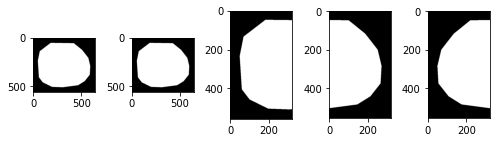

In [ ]:
# har ikke fået lavet det til en funktion endnu

#import matplotlib.image as mpimg
#import cv2




# Cropping the mask
mask = plt.imread('../data/example_segmentation/ISIC_0004337_segmentation.png')

test_asymmetry(mask)


# x_min, x_max, y_min, y_max = get_mask_size(mask)

# mask_cropped = mask[y_min-5:y_max+5, x_min-5:x_max+5]

# # View left half of the x-axis
# x_half = (x_max - x_min) / 2 + x_min # Gives us the middle 

# mask_x_half_left = mask[y_min-5:y_max+5, x_min-5:int(x_half)]
# mask_x_half_right = mask[y_min-5:y_max+5, int(x_half):x_max+5]

# mask_x_half_right_flipped = np.fliplr(mask_x_half_right)

# x_diff = mask_x_half_left - mask_x_half_right_flipped

# # Fold in half y-axis
# y_half = (y_max - y_min) / 2 + y_min # Gives us the middle 

# mask_y_half_left = mask[y_min-5:int(y_half), x_min-5:x_max+5]
# mask_y_half_right = mask[int(y_half):y_max+5, x_min-5:x_max+5]

# mask_y_half_right_flipped = np.flipud(mask_y_half_right)

# y_diff = mask_y_half_left - mask_y_half_right_flipped


# # Calculing diff

# gray1 = np.count_nonzero(x_diff == 0)
# non_gray1 = np.count_nonzero(x_diff)

# print(non_gray1)

# gray1 = np.count_nonzero(y_diff == 0)
# non_gray1 = np.count_nonzero(y_diff)

# print(non_gray1)

# # Displaying the output for vertical
# fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(7, 4))
# axes[0].imshow(mask_cropped,cmap='gray')
# axes[1].imshow(mask_cropped_rotate, cmap="gray")
# axes[2].imshow(mask_x_half_left,cmap='gray')
# axes[3].imshow(mask_x_half_right,cmap='gray')
# axes[4].imshow(x_diff,cmap='gray')
# fig.tight_layout()

# fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(7, 4))
# axes[0].imshow(mask_cropped,cmap='gray')
# axes[1].imshow(mask_y_half_left,cmap='gray')
# axes[2].imshow(mask_y_half_right,cmap='gray')
# axes[3].imshow(y_diff,cmap="gray")
# fig.tight_layout()

# # Flipping the mask vertically and horizontally
# mask_ver = np.fliplr(mask_cropped)
# mask_hor = np.flipud(mask_cropped)





# # Displaying the output for horizontal
# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7, 4))
# axes[0].imshow(mask_cropped,cmap='gray')
# axes[1].imshow(mask_hor,cmap='gray')
# fig.tight_layout()



20202
14010


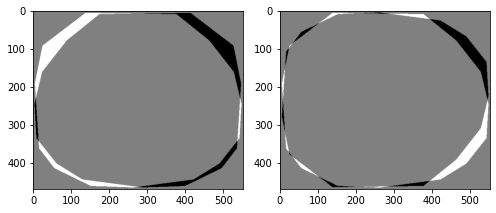

In [ ]:
# Subtract the masks from each other to get the difference

image_diff1 = mask_cropped - mask_ver
image_diff2 = mask_cropped - mask_hor

# Counting number of gray and non-gray pixels
gray1 = np.count_nonzero(image_diff1 == 0)
non_gray1 = np.count_nonzero(image_diff1)

print(non_gray1)

gray2 = np.count_nonzero(image_diff2 == 0)
non_gray2 = np.count_nonzero(image_diff2)

print(non_gray2)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7, 4))
axes[0].imshow(image_diff1,cmap='gray')
axes[1].imshow(image_diff2,cmap='gray')
fig.tight_layout()

In [ ]:
# Inspect an entire np array (only consists of -1, 0, 1)
#import sys
#np.set_printoptions(threshold=sys.maxsize)
#image_diff1

# Counting number of gray and non-gray pixels
gray1 = np.count_nonzero(image_diff1 == 0)
non_gray1 = np.count_nonzero(image_diff1)

gray2 = np.count_nonzero(image_diff2 == 0)
non_gray2 = np.count_nonzero(image_diff2)

print("Left picture")
print("Number of gray pixels is " + str(gray1))
print("Number of non-gray pixels is " + str(non_gray1))
print("Number of gray pixels compared to non-gray pixels is " + str(gray1 / non_gray1))
print(" ")
print("Right picture")
print("Number of gray pixels is " + str(gray2))
print("Number of non-gray pixels is " + str(non_gray2))
print("Number of gray pixels compared to non-gray pixels is " + str(gray2 / non_gray2))
print(" ")

Left picture
Number of gray pixels is 325194
Number of non-gray pixels is 19306
Number of gray pixels compared to non-gray pixels is 16.84419351496944
 
Right picture
Number of gray pixels is 325738
Number of non-gray pixels is 18762
Number of gray pixels compared to non-gray pixels is 17.361581920903955
 


In [ ]:
# Getting a symmetry value - Ivan Petrov's implementation
# He uses a list of lists with points of the outline as input

def symcheck(outline):
    left={}
    right={}
    outlineset=set([x[0] for x in outline])#making a set with all column numbers in the outline
    rowset=set([x[1] for x in outline])#making a set with all row numbers in the outline
    mincol=min(outlineset)
    maxcol=max(outlineset)
    minrow=min(rowset)
    maxrow=max(rowset)
    middlerow=round((maxrow+minrow)/2)
    #checking if the shape is even or odd, assigning a middle column based on that
    if (maxcol+mincol) % 2!=1:
        middlecol=int((maxcol+mincol)/2+0.5)
        for i in range(mincol,middlecol):#making dictinaries for both sides where entries are {column:[rows with pixels]}
            left[i]=[]
        for i in range(middlecol+1,maxcol+1):
            right[i]=[]
        for i in outline:
            if i[0]<middlecol:
                left[i[0]].append(i[1])
            elif i[0]>middlecol:
                right[i[0]].append(i[1])
        even=False
    else:#same thing but for even values of width
        middlecol=[int((maxcol+mincol)/2),int((maxcol+mincol)/2+1)]
        for i in range(mincol,middlecol[0]):
            left[i]=[]
        for i in range(middlecol[1]+1,maxcol+1):
            right[i]=[]
        for i in outline:
            if i[0]<middlecol[0]:
                left[i[0]].append(i[1])
            elif i[0]>middlecol[1]:
                right[i[0]].append(i[1])
        even=True
    if [] in left.values() or [] in right.values():
        return False
    leftcounter=mincol#setting the start values for both 
    rightcounter=maxcol
    leftdistance=0
    rightdistance=0
    for i in range(len(left)):
        for j in left[leftcounter]:
            curlist=right[rightcounter]#finding corresponding list on the other side
            distancelist=[abs(x-j) for x in curlist]
            closest=curlist[distancelist.index(min(distancelist))]#getting the closest pixel
            if even==True:
                leftdistance=leftdistance+math.sqrt((abs(j-middlerow)**2)+(abs(leftcounter-middlecol[0])**2))
                rightdistance=rightdistance+math.sqrt((abs(rightcounter-middlecol[1])**2)+(abs(closest-middlerow)**2))
            else:
                leftdistance=leftdistance+math.sqrt((abs(j-middlerow)**2)+(abs(leftcounter-middlecol)**2))
                rightdistance=rightdistance+math.sqrt((abs(rightcounter-middlecol)**2)+(abs(closest-middlerow)**2))
        leftcounter+=1
        rightcounter-=1
    print('The vertical symmetry value for this shape is:',abs(rightdistance-leftdistance))
    return abs(rightdistance-leftdistance)

### The following two cells can maybe be deleted

In [ ]:
#Trying to compute percentage of non-gray pixels

arr = mask_cropped - mask_ver
#list1 = arr.tolist()
#print(list1)
#plt.hist(image_diff1)

#res = (len([ele for ele in list1 if -0.50 > ele > 0.5]) / len(list1)) * 100

#percentage of black elements/pixels
res1 = (len(list(filter(lambda ele: ele > 0.5, arr.any()))) / len(arr.any())) * 100
  
#percentage of white elements/pixels
res2 = (len(list(filter(lambda ele: ele < -0.5, arr.any()))) / len(arr.any())) * 100

res = res1 + res2
print("non-gray elements percentage : " + str(res))

TypeError: 'numpy.bool_' object is not iterable

In [ ]:
# Subtracting images to see non-overlapping parts

def get_difference(image_path_1, image_path_2, cnt):
    image1 = cv2.imread(image_path_1)
    image2 = cv2.imread(image_path_2)
    difference = cv2.subtract(image1, image2)
    Conv_hsv_Gray = cv2.cvtColor(difference, cv2.COLOR_BGR2GRAY)
    ret, mask = cv2.threshold(Conv_hsv_Gray, 0, 255,cv2.THRESH_BINARY_INV |cv2.THRESH_OTSU)
    difference[mask != 255] = [0, 0, 255]
    image1[mask != 255] = [0, 0, 255]
    image2[mask != 255] = [0, 0, 255]
    #cv2.imwrite(root_path + str(filename) + '{}.png'.format(lista[1]), roi_r)
    cv2.imwrite('image_path_1' + str(cnt) + '.png', image1)

get_difference(mask_cropped, mask_ver, 1)
get_difference(mask_cropped, mask_hor, 1)


#astype(float)

TypeError: Can't convert object of type 'numpy.ndarray' to 'str' for 'filename'

## Border

In [ ]:
from skimage.morphology import opening
def find_border(mask):
    """Returns a ratio between the surcumfrance and the area of a mask. 
    It returns 0 for a perfect circle, and increasingly higher returns for larger 
    surcomfrance compared with area."""
    # Using the fact that all values within the area of the mask is 1, 
    # the area is equal to the sum of the mask
    ones = np.sum(mask)
    # Applying a gausian border to find the surcumfrance
    border = filters.difference_of_gaussians(mask,1) 
    # Reducing the size of the border.

    border = np.where((border < -0.01) & (border > 0.01), 1, border)
    border = np.where(border < 0.01 , 0, border)


    surcumfrance = np.sum(border)

    #plt.imshow(border, cmap='gray')

    Compactness = surcumfrance**2/ones*12


    return(Compactness)

find_border(mask)
test_square = np.pad(np.ones((100,200)), pad_width = 5, constant_values=0)
test_big_square = np.pad(np.ones((1000,2000)), pad_width = 5, constant_values=0)
# find_border(test_big_square)
# find_border(test_square)

# Idea from https://stackoverflow.com/questions/10031580/how-to-write-simple-geometric-shapes-into-numpy-arrays
xx, yy = np.mgrid[:200, :200]

circle = (xx - 100) ** 2 + (yy - 100) ** 2
circle1 = np.where(circle < 1500, 1, circle)
circle1 = np.where(circle1 > 1, 0, circle1)
circle2 = np.where(circle < 1850, 1, circle)
circle2 = np.where(circle2 > 1, 0, circle2)
# find_border(circle1)
# find_border(circle2)






## Colour

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# from skimage.data import astronaut
# from skimage.color import rgb2gray
from skimage.color import label2rgb
# from skimage.filters import sobel
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float

def test_color(image, mask):
    # Have to do this in order for skimage to work properly
    mask = img_as_float(mask[::2, ::2])
    image = img_as_float(image[::2, ::2])

    segments = slic(image, n_segments= 20, compactness=3,sigma= 5, max_iter=10, mask=mask)

    blended_colors = label2rgb(segments, image, kind="avg", bg_label=0)

    specific_colors = np.unique(blended_colors)

    # Average of the colors of the lesion
    # Subtract the highest color spot from the average

    skin_color_treshold = 0.3
    to_avg = []

    for spot_color in specific_colors:
        if spot_color > skin_color_treshold:
            to_avg.append(spot_color)

    highest = specific_colors[-1]
    average = sum(to_avg) / len(to_avg)

    return highest - average

    # -----

    # Okay method to test for cancer

    # for i in range(-2, -10, -1): # Check the color difference from the 9 highest valued segments
    #     #print(highest - specific_colors[i])
    #     if ((highest - specific_colors[i]) > threshold):
    #         print("Cancerous")
    #         break


    # fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
    # axes[0][0].imshow(mask)
    # axes[0][1].imshow(image)
    # axes[1][0].imshow(blended_colors)
    # axes[1][1].imshow(mark_boundaries(image, segments, color=(0,0,0)))
    # fig.tight_layout()

# # Threshold
# threshold_for_cancer = 0.18

# # Cancer free
# x_min, x_max, y_min, y_max = get_mask_size('../data/example_segmentation/ISIC_0004337_segmentation.png')

# mask = plt.imread('../data/example_segmentation/ISIC_0004337_segmentation.png')
# mask = mask[x_min:x_max, y_min:y_max]

# image = plt.imread('../data/example_image/ISIC_0004337.jpg')
# image = image[x_min:x_max, y_min:y_max]

# diff = test_color(image, mask)

# if diff > threshold_for_cancer:
#     print("Cancerous")
# else:
#     print("Not Cancerous")
# # ---------- # ----------

# x_min, x_max, y_min, y_max = get_mask_size(mask)

# mask = plt.imread('../data/example_segmentation/ISIC_0013010_segmentation.png')
# mask = mask[x_min:x_max, y_min:y_max]

# image = plt.imread('../data/example_image/ISIC_0013010.jpg')
# image = image[x_min:x_max, y_min:y_max]

# diff = test_color(image, mask)

# if diff > threshold_for_cancer:
#     print("Cancerous")
# else:
#     print("Not Cancerous")

# Cancer
# mask = plt.imread('../data/example_segmentation/ISIC_0014809_segmentation.png')
# mask = mask[1000:4500, 1500:5000]

# image = plt.imread('../data/example_image/ISIC_0014809.jpg')
# image = image[1000:4500, 1500:5000]

# test_color(image, mask)
# --------
# mask = plt.imread('../data/example_segmentation/ISIC_0013663_segmentation.png')
# mask = mask[0:2450, 1300:3100]

# image = plt.imread('../data/example_image/ISIC_0013663.jpg')
# image = image[0:2450, 1300:3100]

# test_color(image, mask)


# Task 2: Predict the diagnosis
Split your data so that you are have training data and hold-out test data. Use
the training data to train different classifiers and investigate their parameters.
Once you made a choice, evaluate your classifier on the hold-out test data. Think
of different metrics you can use, and different ways to present your results.

x_min:  1340
x_max:  1745


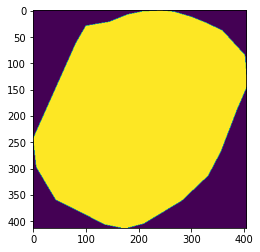

In [ ]:
def get_mask_size(mask):

    i, j = np.where(mask)

    x_min = j.min()
    x_max = j.max()
    y_min = i.min()
    y_max = i.max()

    # mask_size = np.argwhere(mask == 1)

    # x_min = 10000000
    # x_max = 0
    # y_min = 10000000
    # y_max = 0

    # for i in mask_size:
    #     if i[1] < x_min:
    #         x_min = i[1]
    #     elif i[1] > x_max:
    #         x_max = i[1]
    #     if i[0] < y_min:
    #         y_min = i[0]
    #     elif i[0] > y_max:
    #         y_max = i[0]

    return x_min, x_max, y_min, y_max
    

mask = plt.imread('../data/example_segmentation/ISIC_0013010_segmentation.png')

x_min, x_max, y_min, y_max = get_mask_size(mask)
print("x_min: ", x_min)
print("x_max: ", x_max)
plt.imshow(mask[y_min:y_max, x_min:x_max])


## Preparing machine learning
The data is split into training and the data that will be learned on, and the features are extracted

In [ ]:
picture_frame = pd.DataFrame.from_dict(PICTURES, orient='index',)
picture_frame.drop(["training_data.csv", "factors.csv"], inplace = True)
picture_frame

,0
ISIC_0012222_segmentation.png,../data/example_segmentation/ISIC_0012222_segm...
ISIC_0007332_segmentation.png,../data/example_segmentation/ISIC_0007332_segm...
ISIC_0012746_segmentation.png,../data/example_segmentation/ISIC_0012746_segm...
ISIC_0013010_segmentation.png,../data/example_segmentation/ISIC_0013010_segm...
ISIC_0013215_segmentation.png,../data/example_segmentation/ISIC_0013215_segm...
...,...
ISIC_0014637.jpg,../data/example_image/ISIC_0014637.jpg
ISIC_0003657.jpg,../data/example_image/ISIC_0003657.jpg
ISIC_0012256_superpixels.png,../data/example_image/ISIC_0012256_superpixels...
ISIC_0015243.jpg,../data/example_image/ISIC_0015243.jpg


In [ ]:
counts, unique = np.unique(y_train, return_counts=True)
print(counts, unique)

[0. 1.] [56 19]


In [ ]:
# This takes a very long time. Run this at your own risk...

x_train, x_test, y_train, y_test = train_test_split(images['image_id'], images['melanoma'], test_size = 0.3, random_state = 4)

# x_train_data = []
# for test, picture in enumerate(x_train):
#     test_picture = list(image_merge['path'][image_merge['image_id'] == picture])
#     print("name_found")
#     #print(test_picture)
#     # Load in the mask and picture
#     temp = []
#     mask = plt.imread(test_picture[0])
#     raw_pict = plt.imread(test_picture[-1])
#     print("Picture loaded")
#     # Finding the boundaries of the mask.
#     x_min, x_max, y_min, y_max = get_mask_size(mask)
#     # 
#     if x_min > 5:
#         mask = mask[:, x_min-5:]
#         raw_pict = raw_pict[:, x_min-5:]
#     if y_min > 5:
#         mask = mask[y_min-5:,:]
#         raw_pict = raw_pict[y_min-5:,:]    
#     if x_max < mask.shape[1]:
#         mask = mask[:,:x_max+5]
#         raw_pict = raw_pict[:,:x_max+5]
#     if  y_max < mask.shape[0]:
#         mask = mask[:y_max+5,:]
#         raw_pict = raw_pict[:y_max+5,:]
#     print("mask-fitted")
#     temp.append(find_border(mask))
#     print("border found")
#     temp.append(test_color(raw_pict,mask))
#     print("colour found")
#     x_train_data.append(temp)
#     print(test)
    
# x_test_data = []
# for test, picture in enumerate(x_test):
#     test_picture = list(image_merge['path'][image_merge['image_id'] == picture])
#     #print(test_picture)
#     # Load in the mask and picture
#     temp = []
#     mask = plt.imread(test_picture[0])
#     raw_pict = plt.imread(test_picture[-1])
#     # Finding the boundaries of the mask.
#     x_min, x_max, y_min, y_max = get_mask_size(mask)
#     # Only applying the border if the 
#     if x_min > 5:
#         mask = mask[:, x_min-5:]
#         raw_pict = raw_pict[:, x_min-5:]
#     if y_min > 5:
#         mask = mask[y_min-5:,:]
#         raw_pict = raw_pict[y_min-5:,:]    
#     if x_max < mask.shape[1]:
#         mask = mask[:,:x_max+5]
#         raw_pict = raw_pict[:,:x_max+5]
#     if  y_max < mask.shape[0]:
#         mask = mask[:y_max+5,:]
#         raw_pict = raw_pict[:y_max+5,:]
#     temp.append(find_border(mask))
#     temp.append(test_color(raw_pict,mask))
#     x_test_data.append(temp)
#     print(test)

# # print(x_train_data)

(0, 5642, 0, 4315)
(4419, 6688)


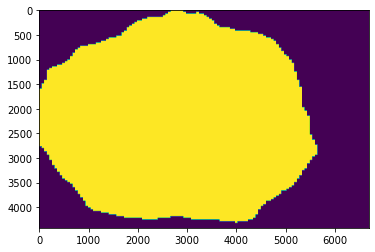

In [ ]:
problems = ["ISIC_0015313" , "ISIC_0013828", "ISIC_0015211"]
test_picture = list(image_merge['path'][image_merge['image_id'] == problems[0]])
mask = plt.imread(test_picture[0])
plt.imshow(mask)
print(get_mask_size(mask))
print(mask.shape)

### Making the test
With the data gathered, we triain the model

In [ ]:
# df_train = pd.DataFrame.from_records(x_train_data, columns = ("compactness", "colour"))
# df_train.to_csv("../data/training_data.csv")
# df_test= pd.DataFrame.from_records(x_test_data, columns = ("compactness", "colour"))
# df_test.to_csv("../data/test_data.csv")

In [ ]:
df_test

,compactness,colour
0,9.850088,0.241259
1,9.364707,0.161396
2,15.610830,0.204740
3,14.537474,0.252545
4,13.088989,0.187594
5,9.770456,0.219732
6,20.594539,0.299262
7,9.307642,0.146305
8,9.215936,0.168972
9,17.410129,0.191588


In [ ]:
df_train = pd.read_csv("../data/training_data.csv")
df_test = pd.read_csv("../data/test_data.csv")

In [ ]:
df_train = df_train.drop(labels = "Unnamed: 0", axis= 1)

In [ ]:
# Let's scale the features
from sklearn import preprocessing

#Fit scaler on our data
scaler = preprocessing.StandardScaler().fit(df_train)

#Apply to data itself
df2 = scaler.transform(df_train)
df2

array([[-8.60677612e-01, -2.37752090e-02],
       [ 2.42169097e-01, -8.80613623e-01],
       [ 3.85924830e-01,  8.61911007e-01],
       [-1.15159607e+00,  1.65379492e+00],
       [ 4.55703144e-01, -1.43663813e+00],
       [ 2.27696533e-01, -2.00938449e-01],
       [-3.79684712e-01,  9.30075432e-01],
       [-1.35932226e+00, -1.27104552e-01],
       [ 4.26053849e-02,  4.32188449e-01],
       [ 6.33998567e-01,  5.13587214e-01],
       [-8.30722223e-01, -3.50011425e-01],
       [ 2.67667473e-01, -3.03174675e-01],
       [-2.66825414e-01,  2.01676117e-04],
       [ 7.45692827e-01,  1.40820994e+00],
       [ 4.10721538e-01,  1.93678209e+00],
       [ 1.77872599e-01, -4.48263534e-01],
       [-8.75594675e-02, -4.74830403e-01],
       [ 2.23294213e+00,  2.16923136e+00],
       [ 1.31206688e+00,  9.32977708e-03],
       [-1.12110963e+00, -8.37407629e-01],
       [-2.92781926e-01,  2.15224372e+00],
       [ 1.68950257e+00, -3.38328446e-01],
       [-1.12926341e+00, -3.02918458e-01],
       [-1.

/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


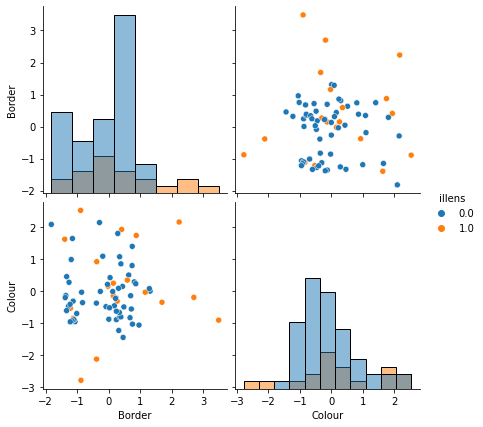

In [ ]:
import seaborn as sns
df = pd.DataFrame(df2, columns = ["Border", "Colour"])
df['illens'] = y_train.tolist()

sns.pairplot(df, hue="illens", size=3,diag_kind="hist")

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
def make_knn_prediction(k):
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(df['Border'], df['illens'])
    answer = knn.predict(df['Border'])
    return answer
make_knn_prediction(5)

ValueError: Expected 2D array, got 1D array instead:
array=[-8.60677612e-01  2.42169097e-01  3.85924830e-01 -1.15159607e+00
  4.55703144e-01  2.27696533e-01 -3.79684712e-01 -1.35932226e+00
  4.26053849e-02  6.33998567e-01 -8.30722223e-01  2.67667473e-01
 -2.66825414e-01  7.45692827e-01  4.10721538e-01  1.77872599e-01
 -8.75594675e-02  2.23294213e+00  1.31206688e+00 -1.12110963e+00
 -2.92781926e-01  1.68950257e+00 -1.12926341e+00 -1.06912312e+00
 -1.10235248e+00 -1.01431498e+00  1.15767853e+00 -1.88921145e-01
  1.46750475e-01 -1.21597094e+00  3.48520715e-01 -1.33452428e+00
  7.40496093e-01  8.72788029e-01  4.37834095e-01 -1.16039392e+00
  3.85637689e-01  4.80057105e-01  7.52959925e-01  3.36681446e-01
  2.56868525e-02 -1.22051653e+00 -8.81207646e-01  1.43015798e-01
  6.75162997e-01 -1.27648751e+00  9.60389810e-01  8.10764081e-01
  2.16777831e-01  7.17037384e-01 -8.92855141e-01 -3.86461738e-01
 -1.39574945e+00 -1.33764977e+00  3.10669052e-01  6.95325276e-01
 -1.22583283e+00  1.28158999e-01  5.91800343e-01 -2.40719697e-02
 -1.82101587e+00 -3.90575458e-02  3.18547587e-01 -1.19025580e+00
  2.87336023e-01  3.44907804e-01  2.76822047e-03 -1.38042914e+00
 -1.25921906e+00  8.57838870e-01  3.48556559e+00 -3.90676498e-01
  2.69989855e+00  1.28764686e+00  2.43364481e-01].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
df

,Border,Colour,illens
0,-0.860678,-0.023775,0.0
1,0.242169,-0.880614,0.0
2,0.385925,0.861911,0.0
3,-1.151596,1.653795,0.0
4,0.455703,-1.436638,0.0
...,...,...,...
70,3.485566,-0.896081,1.0
71,-0.390676,-0.364396,0.0
72,2.699899,-0.184866,1.0
73,1.287647,0.089329,0.0


# Task 3: open question
Use the data to formulate, motivate, answer, and discuss another research question of your choice. You may use other data or features here, that we did not
cover

## Research Question: How does skin colour affect likelihood of Cancer?

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=6c6ff636-1d68-49e2-b04b-ee0d9895f3db' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>